In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt 


from dictionary_learner import (
    Layer, LazyMarginals, KL,
    EntropyCache, SupportCache
)


In [ ]:

def generate_binary_model(
    N=5000,
    th1=0.1, th2=0.2, th3=-0.1,
    th12=1.0, th23=0.6,
    th123=0.0,       
):
    states = list(itertools.product([0,1], repeat=3))
    logp = []

    for x1, x2, x3 in states:
        lp = (
            th1*x1 + th2*x2 + th3*x3
            + th12*(x1*x2)
            + th23*(x2*x3)
            + th123*(x1*x2*x3)
        )
        logp.append(lp)

    logp = np.array(logp)
    p = np.exp(logp - logp.max())
    p /= p.sum()

    idx = np.random.choice(len(states), size=N, p=p)
    return np.array([states[i] for i in idx])


atom (2,) imp= 0.01571157857483385
atom (0,) imp= 0.07598028592759654
atom (1,) imp= 0.13977283762464404
atom (0, 1) imp= 0.016733697596702228
atom (1, 2) imp= 0.008967460743020027
atom (2,) imp= 0.017853788244904897
atom (0,) imp= 0.0782705404867175
atom (1,) imp= 0.14955737551033682
atom (0, 1) imp= 0.01928574129157918
atom (1, 2) imp= 0.010012462343716205
atom (2,) imp= 0.0169504714931306
atom (0,) imp= 0.0735672857704171
atom (1,) imp= 0.13931657531684258
atom (0, 1) imp= 0.020731009977958875
atom (1, 2) imp= 0.004942265198659123
atom (2,) imp= 0.020135513550689002
atom (0,) imp= 0.07761241491391502
atom (1,) imp= 0.15027123790730174
atom (0, 1) imp= 0.016489488522375056
atom (1, 2) imp= 0.0054687904774394554
atom (2,) imp= 0.017474505772428636
atom (0,) imp= 0.07876611651970603
atom (1,) imp= 0.14022997217157562
atom (0, 1) imp= 0.02279910991085196
atom (1, 2) imp= 0.006286796607610503
atom (2,) imp= 0.015285724656831201
atom (0,) imp= 0.08868388632615332
atom (1,) imp= 0.14742783

In [ ]:

N_SEEDS = 30
K_MAX   = 3




def run_experiment(X_generator,layer_params):

    KL_runs   = []     #  (n_seeds, K)
    imp_seeds = []     #  (all layers)

    for seed in range(N_SEEDS):

        np.random.seed(seed)

        X = X_generator()

        states, counts = np.unique(X, axis=0, return_counts=True)
        p_emp = counts / counts.sum()
        d = X.shape[1]

     
        lazy_marginals = LazyMarginals(states)
        entropy_cache  = EntropyCache(X)
        support_cache  = SupportCache(X)

        build_kwargs = dict(
            X=X,
            states=states,
            p_emp=p_emp,
            lazy_marginals=lazy_marginals,
            entropy_cache=entropy_cache,
            support_cache=support_cache,
        )

        prev_layer = None
        KLs = []
        imp_all_layers = {}  

        for k in range(1, K_MAX + 1):

            params = layer_params[k]

            layer = Layer(
                k=k,
                sigma=params["sigma"],
                tau=params["tau"],
                prev_layer=prev_layer,
                d=d if k == 1 else None,
                mode="exact"
            ).build(**build_kwargs)

            KLs.append(KL(p_emp, layer.q))

            # accumulate all atom importances
            for S, v in layer.importances.items():
                imp_all_layers[S] = imp_all_layers.get(S, 0.0) + v

            prev_layer = layer

            if len(layer.atoms) == 0:
                break

        KL_runs.append(KLs)
        imp_seeds.append(imp_all_layers)

    KL_runs = np.array(KL_runs)

    
    imp_mean = {}
    for imp in imp_seeds:
        for S, v in imp.items():
            imp_mean[S] = imp_mean.get(S, 0.0) + v

    for S in imp_mean:
        imp_mean[S] /= len(imp_seeds)

    return KL_runs, imp_mean



In [ ]:



# Pairwise model

layer_params = {
    1: dict(sigma=0.0,   tau=0.0),
    2: dict(sigma=1e-1,  tau=2e-3),
    3: dict(sigma=1e-12, tau=2e-2),
}

KL_runs_pair, imp_pair_mean = run_experiment(
    lambda: generate_binary_model(N=5000, th123=0.0),layer_params
)

layer_params = {
    1: dict(sigma=0.0,   tau=0.0),
    2: dict(sigma=1e-1,  tau=2e-3),
    3: dict(sigma=1e-12, tau=1e-4),
}

# Triplet model
KL_runs_trip, imp_trip_mean = run_experiment(
    lambda: generate_binary_model(N=8000, th123=1.5),layer_params
)


In [71]:
imp_pair_mean

{(2,): np.float64(0.015650456153643973),
 (0,): np.float64(0.07833700652186854),
 (1,): np.float64(0.14671842252457556),
 (0, 1): np.float64(0.020054348811201616),
 (1, 2): np.float64(0.0076366171933431514)}

In [72]:
imp_trip_mean

{(2,): np.float64(0.21497955620792347),
 (0,): np.float64(0.29668726400185746),
 (1,): np.float64(0.35590117167850543),
 (0, 1): np.float64(0.04165650440682453),
 (1, 2): np.float64(0.03510730385699434),
 (0, 2): np.float64(0.00817227515168304),
 (0, 1, 2): np.float64(0.0075978756393001)}

In [ ]:


plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

order_colors = {
    1: "#4C72B0",  # blue
    2: "#DD8452",  # orange
    3: "#55A868",  # green
}



def plot_kl_halo(ax, KL_runs, title):
    KL_mean = KL_runs.mean(axis=0)
    KL_lo, KL_hi = np.percentile(KL_runs, [10, 90], axis=0)
    Ks = np.arange(1, KL_mean.size + 1)

    ax.plot(Ks, KL_mean, color="black", lw=1.8)
    ax.fill_between(Ks, KL_lo, KL_hi, color="black", alpha=0.15)

    for k, v in zip(Ks, KL_mean):
        ax.scatter(k, v, s=40, color=order_colors[k], zorder=3)

    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(["layer 1", "layer 2", "layer 3"])

    ax.set_ylabel(r"$\mathrm{KL}(p \,\|\, q_{D_{\leq k}})$")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)




def plot_atom_bars(ax, importances, title):
    labels, values, colors = [], [], []

    for S, v in importances.items():
        labels.append(rf"$S={S}$")
        values.append(v)
        colors.append(order_colors[len(S)])

    y = np.arange(len(values))

    ax.barh(y, values, color=colors)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Refined information")
    ax.set_title(title)
    ax.invert_yaxis()





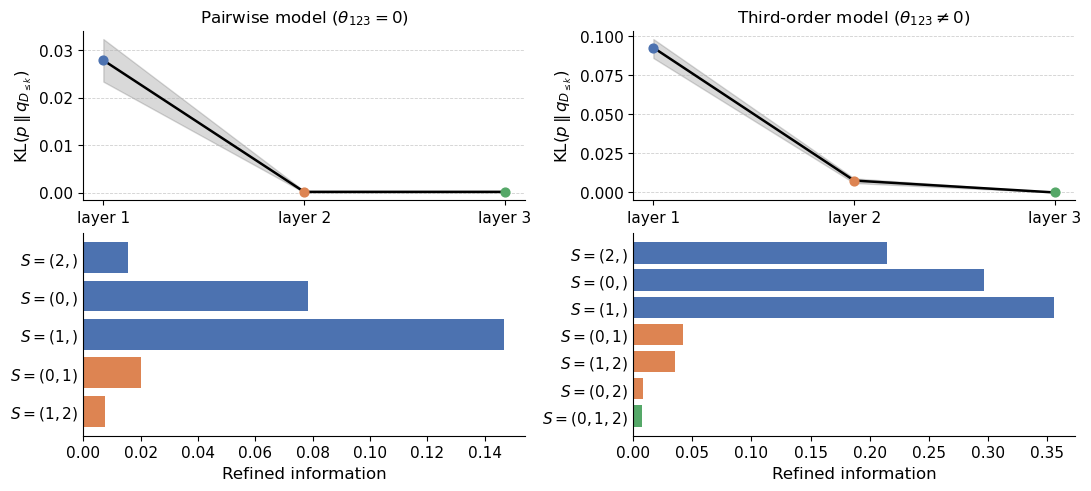

In [ ]:

fig, axes = plt.subplots(
    2, 2,
    figsize=(10.8, 4.8),
    gridspec_kw={"height_ratios": [1.0, 1.2]},
    constrained_layout=True
)


plot_kl_halo(
    axes[0, 0],
    KL_runs_pair,
    title="Pairwise model ($\\theta_{123}=0$)"
)

plot_atom_bars(
    axes[1, 0],
    imp_pair_mean,
    title=""
)



plot_kl_halo(
    axes[0, 1],
    KL_runs_trip,
    title="Third-order model ($\\theta_{123}\\neq0$)"
)

plot_atom_bars(
    axes[1, 1],
    imp_trip_mean,
    title=""
)


for ax in axes[1, :]:
    ax.tick_params(axis="y", length=0)

# plt.savefig("KL_halo_atoms_two_column.pdf", format="pdf")   # savefig svg
plt.show()
